In [1]:
import pandas as pd
import numpy as np
from keras import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, CuDNNLSTM
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
data = pd.read_csv('train.csv').iloc[:, :]
vocab = ['C_E_F_T',
         'C_E_F_C',
         'C_E_F_O',
         'A_E_F_T',
         'A_E_F_O',
         'A_E_F_C',
         'G_E_F_C',
         'G_E_F_T',
         'G_E_F_O',
         'A_E_M_T',
         'A_E_M_O',
         'A_E_M_C',
         'G_E_M_O',
         'G_E_M_C',
         'G_E_M_T',
         'C_E_M_O',
         'C_E_M_C',
         'C_E_M_T',
         'C_H_F_CO',
         'C_H_F_CT',
         'C_H_F_OT',
         'G_H_F_OT',
         'G_H_F_CO',
         'G_H_F_CT',
         'A_H_F_CT',
         'A_H_F_OT',
         'A_H_F_CO',
         'C_H_M_CO',
         'C_H_M_CT',
         'C_H_M_OT',
         'A_H_M_CT',
         'A_H_M_OT',
         'A_H_M_CO',
         'G_H_M_OT',
         'G_H_M_CO',
         'G_H_M_CT', ]

labels = ['correct',
          'wrong',
          'type',
          'orientation',
          'color']

types = ['INTRO',
         'CORE',
         'FLEX',
         'TRIK',
         'DELY'
]

topics = ['cards',
          'animals',
          'geometry'
    
]

feat = ['type',
        'color',
        'orientation',
        'dual'
]

age = ['8-10','11-13']

In [3]:
def seq_to_int(qts,vocab, labels, types, feat, topics, n_steps, age):
    integ = list()
    for i,x in enumerate(qts):
        if i != n_steps:
            features = list()
            #features.append(vocab.index(qts[i, 4]))
            #features.append(qts[i, 2])
            features.append(types.index(qts[i, 9]))
            features.append(feat.index(qts[i, 10]))
            features.append(topics.index(qts[i, 6]))
            features.append(age.index(qts[i, 7]))
            features.append(labels.index(qts[i, 5]))
        else:
            features = list()
            #features.append(vocab.index(qts[i, 4]))
            #features.append(qts[i, 2])
            features.append(types.index(qts[i, 9]))
            features.append(feat.index(qts[i, 10]))
            features.append(topics.index(qts[i, 6]))
            features.append(age.index(qts[i, 7]))
            features.append(-1)
        integ.append(features)
    return integ

def split_sequence(data, n_steps, vocab, labels, types, feat, topics, age):
    X, Y = list(), list()
    users = list(dict.fromkeys(data.loc[:, "user"]))
    for u in users:
        sequence = data[data.user == u]
        for i in range(len(sequence)):
            end_idx = i + n_steps
            if end_idx > len(sequence)-1:
                break
            x = seq_to_int(sequence.iloc[i:end_idx+1, :].values, vocab, labels, types, feat, topics, n_steps, age)
            y = labels.index(str(sequence.iloc[end_idx, 5]))
            X.append(x)
            Y.append(y)
    return np.array(X), np.array(Y)

In [4]:
data_train = data.iloc[:]
y_train = list()
X_train = list()


for i in tqdm(range(10,18)):
    X_seq, y_seq = split_sequence(data_train, i, vocab, labels, types, feat, topics, age)
    for x in X_seq:
        X_train.append(x)
    for _y in y_seq:
        y_train.append(_y)
#y_train = np_utils.to_categorical(y_train)
y_train = np.asarray(y_train)
X_train = np.asarray(X_train)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:24<00:00,  3.01s/it]


In [5]:
X_train = pad_sequences(X_train, value=99)

In [6]:
n_hidden = int(2/3 * (X_train.shape[1]+X_train.shape[2]))

In [38]:
model = Sequential()
model.add(CuDNNLSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=5))
amsgrad = Adam(amsgrad=False)
model.add(Activation('softmax'))
model.compile(optimizer=amsgrad, loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_5 (CuDNNLSTM)     (None, 18, 50)            11400     
_________________________________________________________________
dropout_5 (Dropout)          (None, 18, 50)            0         
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 50)                20400     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 255       
_________________________________________________________________
activation_3 (Activation)    (None, 5)                 0         
Total params: 32,055
Trainable params: 32,055
Non-trainable params: 0
_________________________________________________________________


In [39]:
class_weight = {
    0: 1.,
    1: 1.,
    2: 5.,
    3: 5.,
    4: 5.
}
history = model.fit(X_train, np.asarray(y_train), epochs=500, batch_size=3000, shuffle=True, verbose=2, validation_split=0.1, class_weight=class_weight)

Train on 59133 samples, validate on 6571 samples
Epoch 1/500
 - 1s - loss: 5.9984 - sparse_categorical_accuracy: 0.3013 - val_loss: 5.5979 - val_sparse_categorical_accuracy: 0.3445
Epoch 2/500
 - 0s - loss: 5.5402 - sparse_categorical_accuracy: 0.3043 - val_loss: 5.5919 - val_sparse_categorical_accuracy: 0.3456
Epoch 3/500
 - 0s - loss: 5.3953 - sparse_categorical_accuracy: 0.3133 - val_loss: 5.4896 - val_sparse_categorical_accuracy: 0.3560
Epoch 4/500
 - 1s - loss: 5.3035 - sparse_categorical_accuracy: 0.3473 - val_loss: 5.4414 - val_sparse_categorical_accuracy: 0.3802
Epoch 5/500
 - 0s - loss: 5.2388 - sparse_categorical_accuracy: 0.3851 - val_loss: 5.4032 - val_sparse_categorical_accuracy: 0.4021
Epoch 6/500
 - 0s - loss: 5.1890 - sparse_categorical_accuracy: 0.4002 - val_loss: 5.3782 - val_sparse_categorical_accuracy: 0.3963
Epoch 7/500
 - 0s - loss: 5.1339 - sparse_categorical_accuracy: 0.4166 - val_loss: 5.3329 - val_sparse_categorical_accuracy: 0.3981
Epoch 8/500
 - 0s - loss: 5

Epoch 63/500
 - 0s - loss: 3.0460 - sparse_categorical_accuracy: 0.6673 - val_loss: 3.0712 - val_sparse_categorical_accuracy: 0.6730
Epoch 64/500
 - 0s - loss: 3.0350 - sparse_categorical_accuracy: 0.6643 - val_loss: 3.0791 - val_sparse_categorical_accuracy: 0.6705
Epoch 65/500
 - 0s - loss: 3.0164 - sparse_categorical_accuracy: 0.6689 - val_loss: 3.0754 - val_sparse_categorical_accuracy: 0.6780
Epoch 66/500
 - 0s - loss: 3.0315 - sparse_categorical_accuracy: 0.6645 - val_loss: 3.0559 - val_sparse_categorical_accuracy: 0.6731
Epoch 67/500
 - 0s - loss: 3.0042 - sparse_categorical_accuracy: 0.6705 - val_loss: 3.0406 - val_sparse_categorical_accuracy: 0.6818
Epoch 68/500
 - 0s - loss: 3.0050 - sparse_categorical_accuracy: 0.6683 - val_loss: 3.0375 - val_sparse_categorical_accuracy: 0.6793
Epoch 69/500
 - 0s - loss: 3.0015 - sparse_categorical_accuracy: 0.6695 - val_loss: 3.0157 - val_sparse_categorical_accuracy: 0.6787
Epoch 70/500
 - 0s - loss: 2.9761 - sparse_categorical_accuracy: 0.67

Epoch 125/500
 - 0s - loss: 2.5970 - sparse_categorical_accuracy: 0.7203 - val_loss: 2.6433 - val_sparse_categorical_accuracy: 0.7297
Epoch 126/500
 - 0s - loss: 2.5803 - sparse_categorical_accuracy: 0.7221 - val_loss: 2.6127 - val_sparse_categorical_accuracy: 0.7337
Epoch 127/500
 - 0s - loss: 2.5819 - sparse_categorical_accuracy: 0.7247 - val_loss: 2.6028 - val_sparse_categorical_accuracy: 0.7334
Epoch 128/500
 - 0s - loss: 2.5596 - sparse_categorical_accuracy: 0.7273 - val_loss: 2.5865 - val_sparse_categorical_accuracy: 0.7396
Epoch 129/500
 - 0s - loss: 2.5573 - sparse_categorical_accuracy: 0.7287 - val_loss: 2.5657 - val_sparse_categorical_accuracy: 0.7417
Epoch 130/500
 - 0s - loss: 2.5587 - sparse_categorical_accuracy: 0.7277 - val_loss: 2.5499 - val_sparse_categorical_accuracy: 0.7392
Epoch 131/500
 - 0s - loss: 2.5509 - sparse_categorical_accuracy: 0.7285 - val_loss: 2.5572 - val_sparse_categorical_accuracy: 0.7360
Epoch 132/500
 - 0s - loss: 2.5319 - sparse_categorical_accura

Epoch 187/500
 - 0s - loss: 2.2396 - sparse_categorical_accuracy: 0.7669 - val_loss: 2.2184 - val_sparse_categorical_accuracy: 0.7752
Epoch 188/500
 - 0s - loss: 2.2434 - sparse_categorical_accuracy: 0.7671 - val_loss: 2.1835 - val_sparse_categorical_accuracy: 0.7839
Epoch 189/500
 - 0s - loss: 2.2386 - sparse_categorical_accuracy: 0.7675 - val_loss: 2.2352 - val_sparse_categorical_accuracy: 0.7728
Epoch 190/500
 - 0s - loss: 2.2189 - sparse_categorical_accuracy: 0.7708 - val_loss: 2.1980 - val_sparse_categorical_accuracy: 0.7796
Epoch 191/500
 - 0s - loss: 2.2102 - sparse_categorical_accuracy: 0.7695 - val_loss: 2.2151 - val_sparse_categorical_accuracy: 0.7778
Epoch 192/500
 - 0s - loss: 2.2147 - sparse_categorical_accuracy: 0.7702 - val_loss: 2.1933 - val_sparse_categorical_accuracy: 0.7825
Epoch 193/500
 - 0s - loss: 2.1997 - sparse_categorical_accuracy: 0.7737 - val_loss: 2.2519 - val_sparse_categorical_accuracy: 0.7761
Epoch 194/500
 - 0s - loss: 2.2127 - sparse_categorical_accura

Epoch 249/500
 - 0s - loss: 1.9585 - sparse_categorical_accuracy: 0.7990 - val_loss: 1.9195 - val_sparse_categorical_accuracy: 0.8089
Epoch 250/500
 - 0s - loss: 1.9552 - sparse_categorical_accuracy: 0.8005 - val_loss: 1.8903 - val_sparse_categorical_accuracy: 0.8146
Epoch 251/500
 - 0s - loss: 1.9648 - sparse_categorical_accuracy: 0.7964 - val_loss: 1.9404 - val_sparse_categorical_accuracy: 0.8084
Epoch 252/500
 - 0s - loss: 1.9461 - sparse_categorical_accuracy: 0.8003 - val_loss: 1.9487 - val_sparse_categorical_accuracy: 0.8076
Epoch 253/500
 - 0s - loss: 1.9539 - sparse_categorical_accuracy: 0.8002 - val_loss: 1.9498 - val_sparse_categorical_accuracy: 0.8089
Epoch 254/500
 - 0s - loss: 1.9470 - sparse_categorical_accuracy: 0.8019 - val_loss: 1.8944 - val_sparse_categorical_accuracy: 0.8101
Epoch 255/500
 - 0s - loss: 1.9254 - sparse_categorical_accuracy: 0.8027 - val_loss: 1.9503 - val_sparse_categorical_accuracy: 0.8049
Epoch 256/500
 - 0s - loss: 1.9233 - sparse_categorical_accura

Epoch 311/500
 - 0s - loss: 1.7641 - sparse_categorical_accuracy: 0.8206 - val_loss: 1.7992 - val_sparse_categorical_accuracy: 0.8218
Epoch 312/500
 - 0s - loss: 1.7627 - sparse_categorical_accuracy: 0.8210 - val_loss: 1.7537 - val_sparse_categorical_accuracy: 0.8270
Epoch 313/500
 - 0s - loss: 1.7379 - sparse_categorical_accuracy: 0.8216 - val_loss: 1.7740 - val_sparse_categorical_accuracy: 0.8261
Epoch 314/500
 - 0s - loss: 1.7413 - sparse_categorical_accuracy: 0.8212 - val_loss: 1.7786 - val_sparse_categorical_accuracy: 0.8235
Epoch 315/500
 - 0s - loss: 1.7648 - sparse_categorical_accuracy: 0.8217 - val_loss: 1.7355 - val_sparse_categorical_accuracy: 0.8311
Epoch 316/500
 - 0s - loss: 1.7448 - sparse_categorical_accuracy: 0.8244 - val_loss: 1.7725 - val_sparse_categorical_accuracy: 0.8226
Epoch 317/500
 - 0s - loss: 1.7403 - sparse_categorical_accuracy: 0.8227 - val_loss: 1.7403 - val_sparse_categorical_accuracy: 0.8305
Epoch 318/500
 - 0s - loss: 1.7517 - sparse_categorical_accura

Epoch 373/500
 - 0s - loss: 1.6142 - sparse_categorical_accuracy: 0.8383 - val_loss: 1.6947 - val_sparse_categorical_accuracy: 0.8324
Epoch 374/500
 - 0s - loss: 1.6015 - sparse_categorical_accuracy: 0.8371 - val_loss: 1.6413 - val_sparse_categorical_accuracy: 0.8423
Epoch 375/500
 - 0s - loss: 1.5942 - sparse_categorical_accuracy: 0.8377 - val_loss: 1.6153 - val_sparse_categorical_accuracy: 0.8437
Epoch 376/500
 - 0s - loss: 1.5788 - sparse_categorical_accuracy: 0.8389 - val_loss: 1.6484 - val_sparse_categorical_accuracy: 0.8404
Epoch 377/500
 - 0s - loss: 1.6147 - sparse_categorical_accuracy: 0.8362 - val_loss: 1.6910 - val_sparse_categorical_accuracy: 0.8338
Epoch 378/500
 - 0s - loss: 1.6076 - sparse_categorical_accuracy: 0.8373 - val_loss: 1.5783 - val_sparse_categorical_accuracy: 0.8464
Epoch 379/500
 - 0s - loss: 1.5922 - sparse_categorical_accuracy: 0.8390 - val_loss: 1.6498 - val_sparse_categorical_accuracy: 0.8378
Epoch 380/500
 - 0s - loss: 1.5833 - sparse_categorical_accura

Epoch 435/500
 - 0s - loss: 1.4705 - sparse_categorical_accuracy: 0.8530 - val_loss: 1.5339 - val_sparse_categorical_accuracy: 0.8533
Epoch 436/500
 - 0s - loss: 1.4809 - sparse_categorical_accuracy: 0.8500 - val_loss: 1.5529 - val_sparse_categorical_accuracy: 0.8533
Epoch 437/500
 - 0s - loss: 1.4770 - sparse_categorical_accuracy: 0.8513 - val_loss: 1.5836 - val_sparse_categorical_accuracy: 0.8475
Epoch 438/500
 - 0s - loss: 1.4633 - sparse_categorical_accuracy: 0.8517 - val_loss: 1.6017 - val_sparse_categorical_accuracy: 0.8457
Epoch 439/500
 - 0s - loss: 1.4833 - sparse_categorical_accuracy: 0.8516 - val_loss: 1.5583 - val_sparse_categorical_accuracy: 0.8525
Epoch 440/500
 - 0s - loss: 1.4656 - sparse_categorical_accuracy: 0.8536 - val_loss: 1.5256 - val_sparse_categorical_accuracy: 0.8534
Epoch 441/500
 - 0s - loss: 1.4677 - sparse_categorical_accuracy: 0.8519 - val_loss: 1.5375 - val_sparse_categorical_accuracy: 0.8541
Epoch 442/500
 - 0s - loss: 1.4557 - sparse_categorical_accura

Epoch 497/500
 - 0s - loss: 1.3627 - sparse_categorical_accuracy: 0.8627 - val_loss: 1.4708 - val_sparse_categorical_accuracy: 0.8612
Epoch 498/500
 - 0s - loss: 1.3725 - sparse_categorical_accuracy: 0.8635 - val_loss: 1.4921 - val_sparse_categorical_accuracy: 0.8620
Epoch 499/500
 - 0s - loss: 1.3738 - sparse_categorical_accuracy: 0.8624 - val_loss: 1.4747 - val_sparse_categorical_accuracy: 0.8638
Epoch 500/500
 - 0s - loss: 1.3667 - sparse_categorical_accuracy: 0.8634 - val_loss: 1.4806 - val_sparse_categorical_accuracy: 0.8638


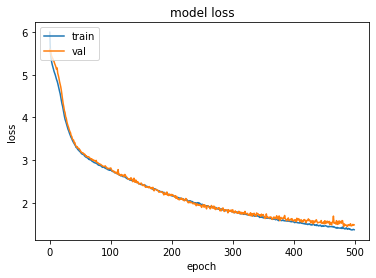

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

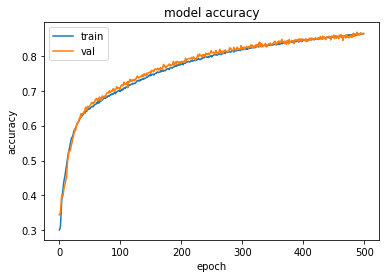

In [41]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

In [42]:
#model.save("model2.h5")
#from keras.models import load_model
#model = load_model("model2.h5")

### Test

In [43]:
data_test = pd.read_csv('test.csv')

In [44]:
y_test = list()
X_test = list()


for i in tqdm(range(10, 18)):
    X_seq, y_seq = split_sequence(data_test, i, vocab, labels, types, feat, topics, age)
    for x in X_seq:
        X_test.append(x)
    for _y in y_seq:
        y_test.append(_y)
#y_test = np_utils.to_categorical(y_test)
y_test = np.asarray(y_test)
X_test = np.asarray(X_test)
X_test = pad_sequences(X_test, value=99)

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.02s/it]


In [45]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
print(accuracy_score(y_test, y_pred.argmax(axis=1)))
matrix = confusion_matrix(y_test, y_pred.argmax(axis=1))
print(matrix)

0.6397805585781646
[[1765   13    0    0    0]
 [ 236    2    0    0    0]
 [   0    0 4732 1224 1332]
 [   0    0 1264 3766 1482]
 [   0    0 1140 1254 3846]]
